# **Quick intro to Optuna** - 5 minutes of fame
## *4 February 2022 @ CzodrowskiLab*

## Aishvarya Tandon
* PhD student - CzodrowskiLab / Waldmann group
* Contact information: [Email](mailto:aishvarya.tandon@tu-dortmund.de), [GitHub](https://github.com/aish-tan)

In the following Jupyter notebook, I will introduce you to Optuna, and why I like it and use it in my workflows.

The following work is based on my opinion. Credits of all the software used and demonstrated belongs to their respective authors and the community.

**License**: MIT

### **What is Optuna?**

Optuna is a hyperparameter optimization software. It is open-source and more information can be found:

1. On developer's [website](https://optuna.org/)
2. On developer's [GitHub page](https://github.com/optuna/optuna)
3. In their [publication](https://arxiv.org/abs/1907.10902) (Akiba, Takuya, et al. "Optuna: A next-generation hyperparameter optimization framework." Proceedings of the 25th ACM SIGKDD international conference on knowledge discovery & data mining. 2019.)

#### **Toy problem:** Models to predict a molecule's average molecular weight from its 2D fingerprint.
Let us prepare data and input strategy which we will use repeatedly in advance.

I will import a subset of randomly selected 50000 compounds from CHEMBL 29

In [1]:
import pandas as pd
df = pd.read_parquet('Shortlisted_Chembl29-4Feb2022.parquet.gzip')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   chembl_id  50000 non-null  object
 1   InChIKey   50000 non-null  object
 2   Smiles     50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


chembl_id                     InChIKey  \
0   CHEMBL424856  KNZSNTNUOIRWRE-UHFFFAOYSA-N   
1  CHEMBL3792491  NTQFMRZDTVXICG-UHFFFAOYSA-N   
2  CHEMBL3900710  IRTOHFGPHMCDRK-UHFFFAOYSA-N   
3    CHEMBL35988  YBIWOQATDVKIPT-UHFFFAOYSA-N   
4  CHEMBL3452898  MMMKGEGGKRMNHL-UHFFFAOYSA-N   

                                              Smiles  
0  CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21  
1     CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC  
2  Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...  
3               CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1  
4   Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O

#### Let us use RDKit's Descriptor module to calculate average molecular weight of these compounds

In [4]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors, MolFromSmiles

df['MolWt'] = df['Smiles'].apply(lambda x: Descriptors.MolWt(MolFromSmiles(x)))
df.head()

chembl_id                     InChIKey  \
0   CHEMBL424856  KNZSNTNUOIRWRE-UHFFFAOYSA-N   
1  CHEMBL3792491  NTQFMRZDTVXICG-UHFFFAOYSA-N   
2  CHEMBL3900710  IRTOHFGPHMCDRK-UHFFFAOYSA-N   
3    CHEMBL35988  YBIWOQATDVKIPT-UHFFFAOYSA-N   
4  CHEMBL3452898  MMMKGEGGKRMNHL-UHFFFAOYSA-N   

                                              Smiles    MolWt  
0  CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21  389.126  
1     CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC  440.584  
2  Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...  500.986  
3               CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1  311.410  
4   Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O  353.403

#### Generating Morgan fingerprints of n_bits = 2048 and radius 3

In [7]:
from rdkit import DataStructs
import numpy as np

def fetch_fp(smile):
    fp = Chem.GetMorganFingerprintAsBitVect(MolFromSmiles(smile), 3, nBits = 2048)
    arr = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    return(arr)

In [8]:
df['Fingerprint'] = df['Smiles'].map(fetch_fp)
df.head()

chembl_id                     InChIKey  \
0   CHEMBL424856  KNZSNTNUOIRWRE-UHFFFAOYSA-N   
1  CHEMBL3792491  NTQFMRZDTVXICG-UHFFFAOYSA-N   
2  CHEMBL3900710  IRTOHFGPHMCDRK-UHFFFAOYSA-N   
3    CHEMBL35988  YBIWOQATDVKIPT-UHFFFAOYSA-N   
4  CHEMBL3452898  MMMKGEGGKRMNHL-UHFFFAOYSA-N   

                                              Smiles    MolWt  \
0  CC1(F)CC(F)(F)c2nn(-c3c(Cl)cc(C(F)(F)F)cc3Cl)cc21  389.126   
1     CCN(CCCCCCNC(=O)C=Cc1ccc(O)c(OC)c1)Cc1ccccc1OC  440.584   
2  Cc1cc(N2C(=O)c3cc(-c4ccn(C)c(=O)c4)n(C4CC4)c3C...  500.986   
3               CC(O)c1cccc(C(C#N)C(=N)Sc2ccccc2N)c1  311.410   
4   Cn1ccc(C(=O)N=c2[nH]c(-c3ccc4c(c3)CCO4)cs2)cc1=O  353.403   

                                         Fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

#### Let us see a distribution of MolWt

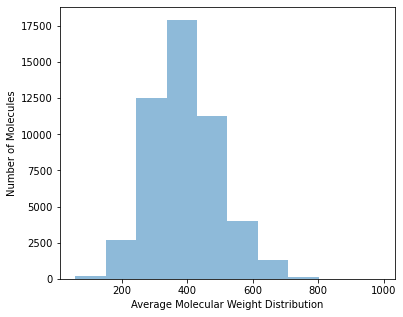

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

df.MolWt.plot.hist(alpha=0.5, figsize=(6, 5))
plt.xlabel('Average Molecular Weight Distribution')
plt.ylabel('Number of Molecules')

plt.show()

#### Let us split the data into train, validation and test sets

In [19]:
import sklearn.model_selection as model_selection

In [20]:
#Splitting full df into training and test set
df_train, df_test  = model_selection.train_test_split(df, train_size=0.8, test_size=0.2, random_state = 50)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [21]:
#Splitting test set into validation and test set
df_test, df_val  = model_selection.train_test_split(df_test, train_size=0.8, test_size=0.2, random_state = 51)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [22]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chembl_id    40000 non-null  object 
 1   InChIKey     40000 non-null  object 
 2   Smiles       40000 non-null  object 
 3   MolWt        40000 non-null  float64
 4   Fingerprint  40000 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


chembl_id                     InChIKey  \
0  CHEMBL1910118  OUZPFPWUZJUWBW-UHFFFAOYSA-N   
1  CHEMBL3701718  OMHKRUKICMAVEQ-UHFFFAOYSA-N   
2  CHEMBL1586469  IZGCNQQYKVLKJF-UHFFFAOYSA-N   
3    CHEMBL15911  LXTWWFKWPYKGDZ-UHFFFAOYSA-N   
4  CHEMBL1977077  XCNVQBYFDVXDCR-UHFFFAOYSA-N   

                                              Smiles    MolWt  \
0  CCN(CC)C(=O)Cn1cc2c(-c3ccc(Cl)cc3Cl)c(CN)c(C)n...  435.355   
1  CC1(O)CC(N)(c2ccc(-c3nc4n(c3-c3ccccc3)COc3cccc...  441.506   
2  O=C(Nc1ccc(O)cc1)c1ccc2c(c1)C(=O)N(Cc1ccccc1)C2=O  372.380   
3                       Nc1ccc2c(c1)Oc1ncccc1C(=O)N2  227.223   
4                 COC(=NN=Cc1ccc(Cl)c(Cl)c1)c1ccncc1  308.168   

                                         Fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [23]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chembl_id    8000 non-null   object 
 1   InChIKey     8000 non-null   object 
 2   Smiles       8000 non-null   object 
 3   MolWt        8000 non-null   float64
 4   Fingerprint  8000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 312.6+ KB


chembl_id                     InChIKey  \
0  CHEMBL3457366  GGROEQZNFUAMRC-UHFFFAOYSA-N   
1  CHEMBL4082919  GIUFLJDLCSSQNX-UHFFFAOYSA-N   
2  CHEMBL3823725  KYFDIOOCZMQBNF-UHFFFAOYSA-N   
3  CHEMBL1205660  FBHBALAPMKYARW-UHFFFAOYSA-N   
4  CHEMBL1371129  UWEYRJFJVCLAGH-UHFFFAOYSA-N   

                                              Smiles    MolWt  \
0   Cc1nc2cc(=O)[nH]n2c(C)c1CC(=O)Nc1cnn(C(C)(C)C)c1  342.403   
1                        Oc1c(C=C2C=CC=N2)oc2ccccc12  211.220   
2       O=C(N=c1[nH]c2ccc(Cl)cc2s1)Nc1ccc(C(=O)O)cc1  347.783   
3   NC(=O)Nc1ccc(NC(=O)N2CCC3C2C(=O)N3S(=O)(=O)O)cc1  369.359   
4  FC1(F)C(F)(F)C(F)(F)C2(F)C(F)(F)C(F)(F)C(F)(F)...  462.074   

                                         Fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [24]:
df_val.info()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   chembl_id    2000 non-null   object 
 1   InChIKey     2000 non-null   object 
 2   Smiles       2000 non-null   object 
 3   MolWt        2000 non-null   float64
 4   Fingerprint  2000 non-null   object 
dtypes: float64(1), object(4)
memory usage: 78.2+ KB


chembl_id                     InChIKey  \
0  CHEMBL1521162  SOWYDDIFKJDJQJ-UHFFFAOYSA-N   
1  CHEMBL2094512  VEGQQKXISPLKFE-UHFFFAOYSA-N   
2  CHEMBL1547923  NGGVSRYVZQZRCT-UHFFFAOYSA-N   
3  CHEMBL4292611  ANBMJCJTPBBGIB-UHFFFAOYSA-N   
4  CHEMBL3310133  SPXCQNAMVXGUIP-UHFFFAOYSA-N   

                                         Smiles    MolWt  \
0               Cc1ccc(C)c(CSCC(=O)NCc2cccs2)c1  305.468   
1     O=c1c(-c2ccccc2)c(-c2ccccc2)[nH]c2ccccc12  297.357   
2  COc1ccc(CCN(C)CC=Cc2ccccc2[N+](=O)[O-])cc1OC  356.422   
3              O=S1(=O)C=C(SC(O)C(O)S)c2ccccc21  290.387   
4     CC(=O)N=c1o[nH]c(-c2ccc(F)cc2)c1-c1ccncc1  297.289   

                                         Fingerprint  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

#### Let us prepare the Xs and Ys

In [25]:
X_train = np.stack(df_train.Fingerprint)
X_test = np.stack(df_test.Fingerprint)
X_val = np.stack(df_val.Fingerprint)

Y_train = df_train['MolWt']
Y_test = df_test['MolWt']
Y_val = df_val['MolWt']

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()
Y_val = Y_val.to_numpy()

In [26]:
print("Shape X_train: ", X_train.shape)
print("Shape Y_train: ", Y_train.shape)
print("Shape X_val: ", X_val.shape)
print("Shape Y_val: ", Y_val.shape)
print("Shape X_test: ", X_test.shape)
print ("Shape Y_test: ", Y_test.shape)

Shape X_train:  (40000, 2048)
Shape Y_train:  (40000,)
Shape X_val:  (2000, 2048)
Shape Y_val:  (2000,)
Shape X_test:  (8000, 2048)
Shape Y_test:  (8000,)


#### Now that we have our data preparations done, let us move to the modelling part.

#### There are 3 main reasons I like using Optuna
1. Easy to install
2. Easy to use
3. Very verbose

We will cover all points.

#### 1. Easy to install

One can simply use either use 'pip' or 'conda' to install Optuna. Optuna needs only handful of packages, so unnecessary cross-compatibility issues are avoided.

`pip install optuna`

or

`conda install -c conda-forge optuna`

#### 2. Easy to use

Optuna is framework agnostic, that means it can run on practically any framework. Here's the best thing - the framework doesn't even need to be a machine learning framework! 

We will do demo modelling on **Tensorflow-Keras, Scikit-Learn's Random Forest,** and **XGBoost** to see how it works. 

##### Study and Trials
Practically only thing one must understand before the usage. In Optuna, one makes a *study* to optimize, for instance, a neural network model to fit your data. To optimize the hyperparameters of this study, *trials* with different hyperparameters are run. Optuna evaluates a trial once it is done training on its set of hyperparameters and selects the best trial. We can use this best trial's hyperparameters to then train the final model. 

To show a very easy example describing *study* and *trials*, and optimization, I am taking this example (and modifying it slightly) posted on Optuna's main webpage:

In this example, we minimize `x` in this simple function: `(x-2)^2`. We suggest the values of `x` (as a float) between -5 and 5. The number of trials is set to 50, meaning, the whole process with different values of `x` will be repeated 100 times. 

In [27]:
import optuna

In [29]:
def objective(trial):
    x = trial.suggest_float('x', -5, 5)
    return (x - 2) ** 2

study = optuna.create_study(direction = 'minimize', study_name = 'minimize_x_study')
study.optimize(objective, n_trials=100)

[I 2022-02-03 17:30:39,065] A new study created in memory with name: minimize_x_study
[I 2022-02-03 17:30:39,069] Trial 0 finished with value: 0.9108178695621746 and parameters: {'x': 1.045632214729471}. Best is trial 0 with value: 0.9108178695621746.
[I 2022-02-03 17:30:39,070] Trial 1 finished with value: 39.55697151495289 and parameters: {'x': -4.289433322243975}. Best is trial 0 with value: 0.9108178695621746.
[I 2022-02-03 17:30:39,071] Trial 2 finished with value: 3.1337800326197214 and parameters: {'x': 0.22975142067004573}. Best is trial 0 with value: 0.9108178695621746.
[I 2022-02-03 17:30:39,072] Trial 3 finished with value: 4.0969587798839635 and parameters: {'x': 4.024094558039215}. Best is trial 0 with value: 0.9108178695621746.
[I 2022-02-03 17:30:39,073] Trial 4 finished with value: 1.2131626435786214 and parameters: {'x': 0.8985633728722195}. Best is trial 0 with value: 0.9108178695621746.
[I 2022-02-03 17:30:39,074] Trial 5 finished with value: 0.06930082365025429 and 

In [30]:
study.best_params

{'x': 1.9995399720194744}

We can see the best trial found was trial 82 with the value 2 x 10^-7 returned, when x = 1.99. This example also shows that Optuna can be used to practically tune any function as long as a value is returned which can determine the direction in which the parameter(s) have to be optimized.   

#### Back to ML algorithms and our problem statement
I will begin with Tensorflow-Keras since I use them most of the time. 

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model

2022-02-03 17:43:19.688986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
#TF configuration
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

In [35]:
def objective(trial):
    
    # We optimize the numbers of layers and their units.
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    #Optimizing number of epochs
    n_epochs = trial.suggest_int("n_epochs", 1, 10)
    
    model = tf.keras.Sequential()
    
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 10, 2000, log=True)
        model.add(Dense(num_hidden, activation="relu"))
    
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
        
    #Optimizing the learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    
    model.compile(loss="mean_squared_error", optimizer= tf.keras.optimizers.Adam(lr=lr), metrics=["mean_absolute_error"])
    
    #Optimizing batch size
    n_batchsize = trial.suggest_int("n_batchsize", 128, 512)
    
    model.fit(
    X_train,
    Y_train,
    #validation_data=(X_val, Y_val),
    shuffle=True,
    batch_size=n_batchsize,
    epochs=n_epochs,
    verbose=False)
        
    eval_loss, eval_accuracy = model.evaluate(X_val, Y_val, verbose=0)
        
    return eval_loss

In [37]:
study = optuna.create_study(direction='minimize', study_name = 'tf-keras_model_optimization')
study.optimize(objective, n_trials=500)

[I 2022-02-03 17:50:42,462] A new study created in memory with name: tf-keras_model_optimization
2022-02-03 17:50:56.489663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-03 17:50:56.989504: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz
2022-02-03 17:51:00.776413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
[I 2022-02-03 17:51:34,104] Trial 0 finished with value: 1598.263427734375 and parameters: {'n_layers': 3, 'n_epochs': 9, 'n_units_l0': 165, 'n_units_l1': 28, 'n_units_l2': 630, 'lr': 0.001960764970029559, 'n_batchsize': 149}. Best is trial 0 with value: 1598.263427734375.
[I 2022-02-03 17:51:35,171] Trial 1 finished with value: 1965.693603515625 and parameters: {'n_layers': 4, 'n_epochs': 2, 'n_units_l0': 126, 'n_units_l1': 12, 'n_units_l2': 17, 'n_units_l3': 143, 'lr': 0.001177929

The best trial can then be assessed.

In [38]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)

Best params:  {'n_layers': 4, 'n_epochs': 10, 'n_units_l0': 1167, 'n_units_l1': 14, 'n_units_l2': 111, 'n_units_l3': 1502, 'lr': 0.00034296931053536195, 'n_batchsize': 161}
Best value:  1159.6004638671875
Best Trial:  FrozenTrial(number=321, values=[1159.6004638671875], datetime_start=datetime.datetime(2022, 2, 3, 18, 13, 40, 855459), datetime_complete=datetime.datetime(2022, 2, 3, 18, 13, 46, 323793), params={'n_layers': 4, 'n_epochs': 10, 'n_units_l0': 1167, 'n_units_l1': 14, 'n_units_l2': 111, 'n_units_l3': 1502, 'lr': 0.00034296931053536195, 'n_batchsize': 161}, distributions={'n_layers': IntUniformDistribution(high=5, low=1, step=1), 'n_epochs': IntUniformDistribution(high=10, low=1, step=1), 'n_units_l0': IntLogUniformDistribution(high=2000, low=10, step=1), 'n_units_l1': IntLogUniformDistribution(high=2000, low=10, step=1), 'n_units_l2': IntLogUniformDistribution(high=2000, low=10, step=1), 'n_units_l3': IntLogUniformDistribution(high=2000, low=10, step=1), 'lr': LogUniformDistr

Here comes the 3rd point about Optuna which I like - **very verbose**.
Optuna has amazing visualizations!

In [39]:
import plotly

In [40]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

This is one of my favorite plots - parameter importance. 

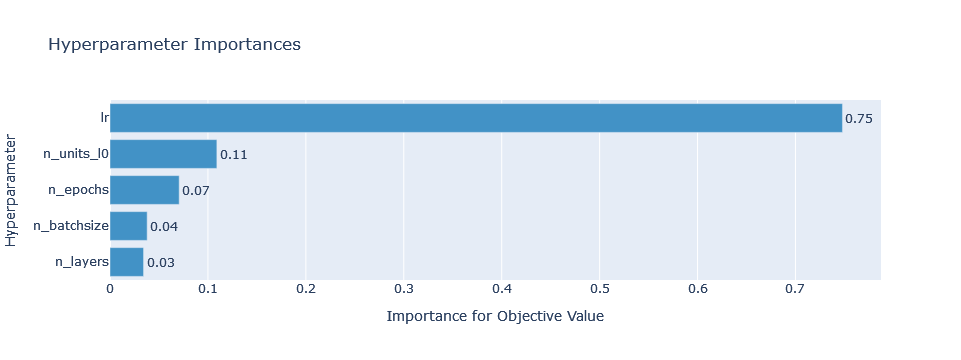

In [41]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

We can see that the learning rate was the most important parameter in this optimization.

Now that we have our best hyperparameters, wouldn't it be nice to save a model and use that model? 

I find this strategy most useful:

In [42]:
#Saving the best model
best_model_name = 'optuna_save_mf_2048'

In [43]:
def detailed_objective(trial):
    
    # We optimize the numbers of layers and their units.
    n_layers = trial.suggest_int("n_layers", 1, 5)
    
    #Optimizing number of epochs
    n_epochs = trial.suggest_int("n_epochs", 1, 10)
    
    model = tf.keras.Sequential()
    
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 10, 2000, log=True)
        model.add(Dense(num_hidden, activation="relu"))
    
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
        
    #Optimizing the learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    
    model.compile(loss="mean_squared_error", optimizer= tf.keras.optimizers.Adam(lr=lr), metrics=["mean_absolute_error"])
    
    #Optimizing batch size
    n_batchsize = trial.suggest_int("n_batchsize", 128, 512)
    
    model.fit(
    X_train,
    Y_train,
    shuffle=True,
    batch_size=n_batchsize,
    epochs=n_epochs,
    verbose=False)
    
    model.save(best_model_name) #This is the only extra step here!
        
    eval_loss, eval_accuracy = model.evaluate(X_val, Y_val, verbose=0)
        
    return eval_loss

In [ ]:
detailed_objective(study.best_trial) 

In [45]:
model = tf.keras.models.load_model(best_model_name)
model.compile()

model.trainable = False

In [46]:
model.summary()

Model: "sequential_500"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2306 (Dense)           (None, 1167)              2391183   
_________________________________________________________________
dense_2307 (Dense)           (None, 14)                16352     
_________________________________________________________________
dense_2308 (Dense)           (None, 111)               1665      
_________________________________________________________________
dense_2309 (Dense)           (None, 1502)              168224    
_________________________________________________________________
dropout_500 (Dropout)        (None, 1502)              0         
_________________________________________________________________
dense_2310 (Dense)           (None, 1)                 1503      
Total params: 2,578,927
Trainable params: 0
Non-trainable params: 2,578,927
__________________________________________

Let us predict on the unseen *test set* and evaluate the performance even more transparently.

In [47]:
#Time to predict the test set
Y_pred = model.predict(X_test)

In [48]:
df_test = pd.DataFrame()
df_test['MolWt_Original'] = Y_test
df_test['MolWt_Predicted'] = Y_pred
df_test.head()

MolWt_Original  MolWt_Predicted
0         342.403       355.755646
1         211.220       323.439545
2         347.783       351.539337
3         369.359       356.450378
4         462.074       410.886566

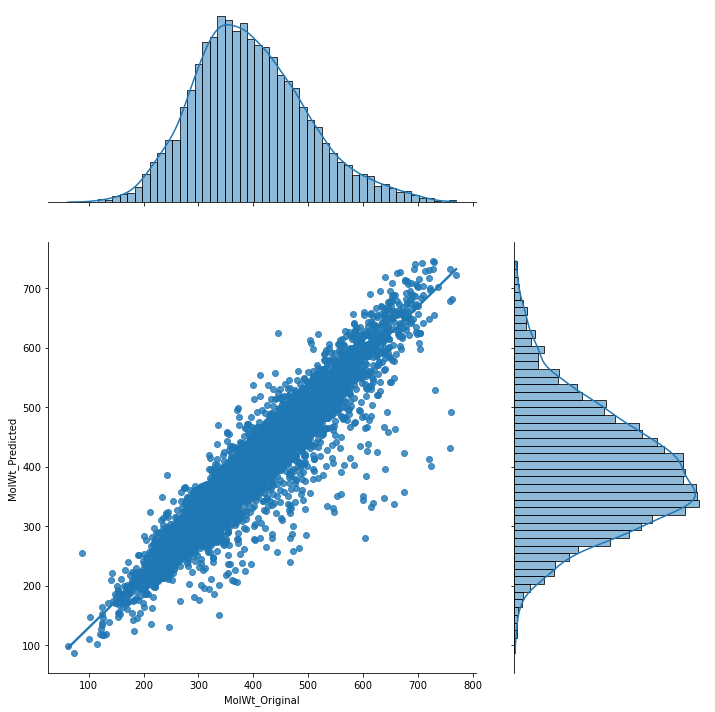

In [49]:
#Visualization
import seaborn as sns

sns.jointplot(data=df_test, x="MolWt_Original", y="MolWt_Predicted", kind="reg", height= 10, ratio=2)

I like this visualization and the model prediction, however, let's read the real metrics.

In [50]:
import sklearn.metrics as metrics

mae = metrics.mean_absolute_error(df_test['MolWt_Original'], df_test['MolWt_Predicted'])
mse = metrics.mean_squared_error(df_test['MolWt_Original'], df_test['MolWt_Predicted'])
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(df_test['MolWt_Original'], df_test['MolWt_Predicted'])


print("Results of sklearn.metrics:")
print("MAE:",mae) 
#(Mean absolute error) represents the difference between the original and 
#predicted values extracted by averaged the absolute difference over the data set

print("MSE:", mse)
# (Mean Squared Error) represents the difference between the original and 
# predicted values extracted by squared the average difference over the data set

print("RMSE:", rmse)
#(Root Mean Squared Error) is the error rate by the square root of MSE

print("R-Squared:", r2)
# (Coefficient of determination) represents the coefficient of how well the values fit 
# compared to the original values. The value from 0 to 1 interpreted as percentages. 
# The higher the value is, the better the model is

Results of sklearn.metrics:
MAE: 22.273297622978216
MSE: 1168.3501686344296
RMSE: 34.18113761469079
R-Squared: 0.8906739338069645


### Scikit-learn's Random Forest regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
def rf_reg_objective(trial):
    
    # Optimizing the numbers of estimators.
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    
    # Optimizing the numbers of max depth.
    max_depth = trial.suggest_int("max_depth", 2, 32)
    
    rf_model = RandomForestRegressor(max_depth= max_depth, n_estimators = n_estimators, n_jobs = 5)
    
    rf_model.fit(X_train, Y_train)
    rf_score = rf_model.score(X_val, Y_val)
    
    return rf_score

In [55]:
rf_study = optuna.create_study(direction="maximize", study_name = 'rf_model_optimization')
rf_study.optimize(rf_reg_objective, n_trials=100)

[I 2022-02-03 19:12:20,460] A new study created in memory with name: rf_model_optimization
[I 2022-02-03 19:13:29,120] Trial 0 finished with value: 0.5761943014155149 and parameters: {'n_estimators': 47, 'max_depth': 30}. Best is trial 0 with value: 0.5761943014155149.
[I 2022-02-03 19:14:10,791] Trial 1 finished with value: 0.2287582402518703 and parameters: {'n_estimators': 86, 'max_depth': 4}. Best is trial 0 with value: 0.5761943014155149.
[I 2022-02-03 19:15:13,745] Trial 2 finished with value: 0.579510264293221 and parameters: {'n_estimators': 46, 'max_depth': 31}. Best is trial 2 with value: 0.579510264293221.
[I 2022-02-03 19:16:37,026] Trial 3 finished with value: 0.5735126322310471 and parameters: {'n_estimators': 67, 'max_depth': 25}. Best is trial 2 with value: 0.579510264293221.
[I 2022-02-03 19:16:49,604] Trial 4 finished with value: 0.5362686528114484 and parameters: {'n_estimators': 10, 'max_depth': 21}. Best is trial 2 with value: 0.579510264293221.
[I 2022-02-03 19:17

In [56]:
print("Best params: ", rf_study.best_params)
print("Best value: ", rf_study.best_value)
print("Best Trial: ", rf_study.best_trial)

Best params:  {'n_estimators': 85, 'max_depth': 32}
Best value:  0.5866889579643882
Best Trial:  FrozenTrial(number=77, values=[0.5866889579643882], datetime_start=datetime.datetime(2022, 2, 3, 20, 45, 27, 838612), datetime_complete=datetime.datetime(2022, 2, 3, 20, 47, 24, 349630), params={'n_estimators': 85, 'max_depth': 32}, distributions={'n_estimators': IntUniformDistribution(high=100, low=10, step=1), 'max_depth': IntUniformDistribution(high=32, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=77, state=TrialState.COMPLETE, value=None)


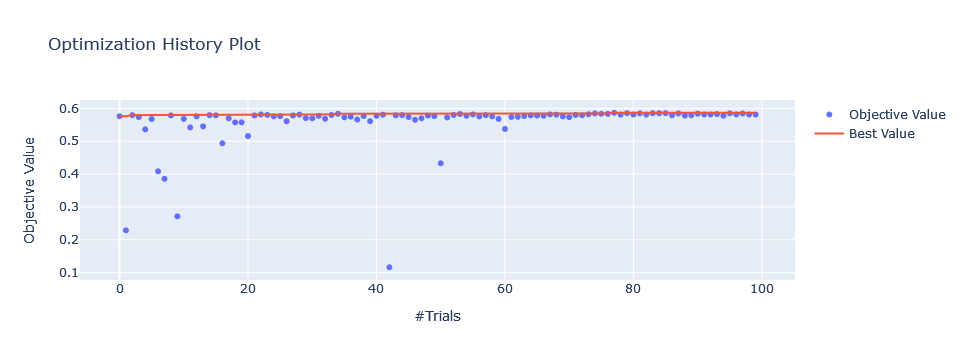

In [57]:
plot_optimization_history(rf_study)

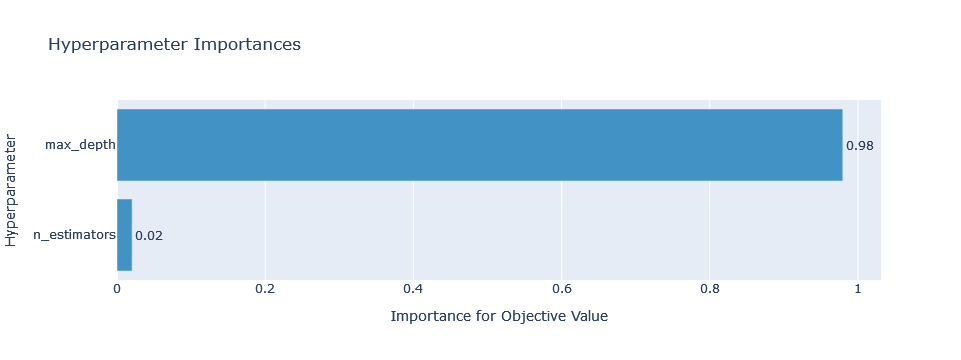

In [58]:
fig = optuna.visualization.plot_param_importances(rf_study)
fig.show()

In [60]:
#We use pickle to save the model this time
import pickle

In [61]:
#Saving the best rf model
best_rf_model_name = 'optuna_save_rf_mf_2048.sav'

In [62]:
def rf_reg_detailed_objective(trial):
    
    # Optimizing the numbers of estimators.
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    
    # Optimizing the numbers of max depth.
    max_depth = trial.suggest_int("max_depth", 2, 32)
    
    rf_model = RandomForestRegressor(max_depth= max_depth, n_estimators = n_estimators, n_jobs = 5)
    
    rf_model.fit(X_train, Y_train)
    rf_score = rf_model.score(X_val, Y_val)
    
    pickle.dump(rf_model, open(best_rf_model_name, 'wb'))
    return rf_score

In [64]:
rf_reg_detailed_objective(rf_study.best_trial) 

0.5826056862121568

Let us repeat the process we did for the TF-Keras NN model and predict on the unseen *test set* and evaluate the performance even more transparently.

In [65]:
#load rf model
rf_model = pickle.load(open(best_rf_model_name, 'rb'))

In [66]:
#Time to predict the test set
Y_pred_rf = rf_model.predict(X_test)

In [70]:
df_test_rf = pd.DataFrame()
df_test_rf['MolWt_Original'] = Y_test
df_test_rf['MolWt_Predicted'] = Y_pred_rf
df_test_rf.head()

MolWt_Original  MolWt_Predicted
0         342.403       399.532159
1         211.220       247.601887
2         347.783       371.364460
3         369.359       375.503253
4         462.074       416.779873

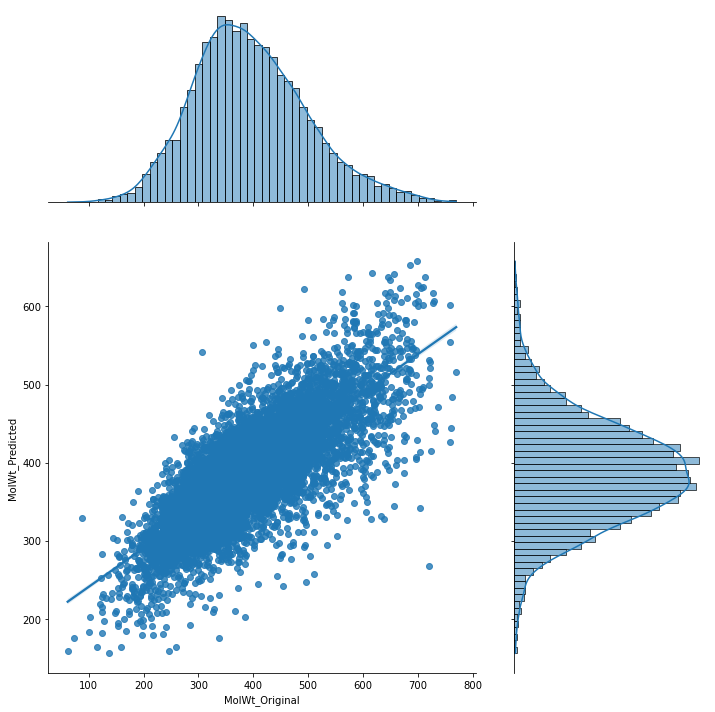

In [71]:
#Visualization

sns.jointplot(data=df_test_rf, x="MolWt_Original", y="MolWt_Predicted", kind="reg", height= 10, ratio=2)

Let's read the performance metrics.

In [72]:
mae = metrics.mean_absolute_error(df_test_rf['MolWt_Original'], df_test_rf['MolWt_Predicted'])
mse = metrics.mean_squared_error(df_test_rf['MolWt_Original'], df_test_rf['MolWt_Predicted'])
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(df_test_rf['MolWt_Original'], df_test_rf['MolWt_Predicted'])


print("Results of sklearn.metrics:")
print("MAE:",mae) 
#(Mean absolute error) represents the difference between the original and 
#predicted values extracted by averaged the absolute difference over the data set

print("MSE:", mse)
# (Mean Squared Error) represents the difference between the original and 
# predicted values extracted by squared the average difference over the data set

print("RMSE:", rmse)
#(Root Mean Squared Error) is the error rate by the square root of MSE

print("R-Squared:", r2)
# (Coefficient of determination) represents the coefficient of how well the values fit 
# compared to the original values. The value from 0 to 1 interpreted as percentages. 
# The higher the value is, the better the model is

Results of sklearn.metrics:
MAE: 50.58160920573863
MSE: 4448.945956146324
RMSE: 66.7004194600478
R-Squared: 0.5836986434817059


At first, the performance of RF doesn't seem to be as good as the NN, however, that is **not** the objective of this modelling example today and might just be because of limited hyperparameters I searched and insufficient number of trials I ran. 

#### XGBoost regressor

In [73]:
import xgboost

In [78]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

def xgb_reg_objective(trial):
    
    # Optimizing the booster category.
    booster = trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"])
    
    #Optimizing the learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1.0, log=True)
    
    xgb_model = XGBRegressor(booster = booster, learning_rate = learning_rate)
    
    xgb_model.fit(X_train, Y_train)
    
    Y_val_pred_xgb = xgb_model.predict(X_val)
    
    return r2_score(Y_val, Y_val_pred_xgb)

In [80]:
xgb_study = optuna.create_study(direction="maximize", study_name = 'xgb_model_optimization')
xgb_study.optimize(xgb_reg_objective, n_trials=10)

[I 2022-02-04 09:48:32,369] A new study created in memory with name: xgb_model_optimization
[I 2022-02-04 09:48:44,152] Trial 0 finished with value: 0.5639202072332369 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0492972294105984}. Best is trial 0 with value: 0.5639202072332369.
[I 2022-02-04 09:48:56,139] Trial 1 finished with value: 0.6024747170271503 and parameters: {'booster': 'gbtree', 'learning_rate': 0.9737873416498332}. Best is trial 1 with value: 0.6024747170271503.
[I 2022-02-04 09:49:00,202] Trial 2 finished with value: -13.789808252683846 and parameters: {'booster': 'gblinear', 'learning_rate': 1.0765508804919085e-08}. Best is trial 1 with value: 0.6024747170271503.
[I 2022-02-04 09:49:04,290] Trial 3 finished with value: -13.157451876928949 and parameters: {'booster': 'gblinear', 'learning_rate': 3.094641283047875e-06}. Best is trial 1 with value: 0.6024747170271503.
[I 2022-02-04 09:51:14,537] Trial 4 finished with value: -13.791980431496688 and parameters: {'

In [81]:
print("Best params: ", xgb_study.best_params)
print("Best value: ", xgb_study.best_value)
print("Best Trial: ", xgb_study.best_trial)

Best params:  {'booster': 'gbtree', 'learning_rate': 0.19962416908157585}
Best value:  0.7226010183083338
Best Trial:  FrozenTrial(number=6, values=[0.7226010183083338], datetime_start=datetime.datetime(2022, 2, 4, 9, 51, 27, 171337), datetime_complete=datetime.datetime(2022, 2, 4, 9, 51, 39, 537189), params={'booster': 'gbtree', 'learning_rate': 0.19962416908157585}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'learning_rate': LogUniformDistribution(high=1.0, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=6, state=TrialState.COMPLETE, value=None)


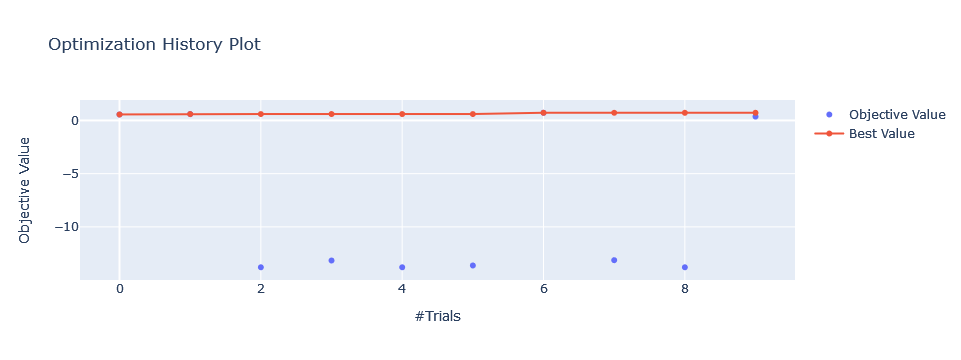

In [82]:
plot_optimization_history(xgb_study)

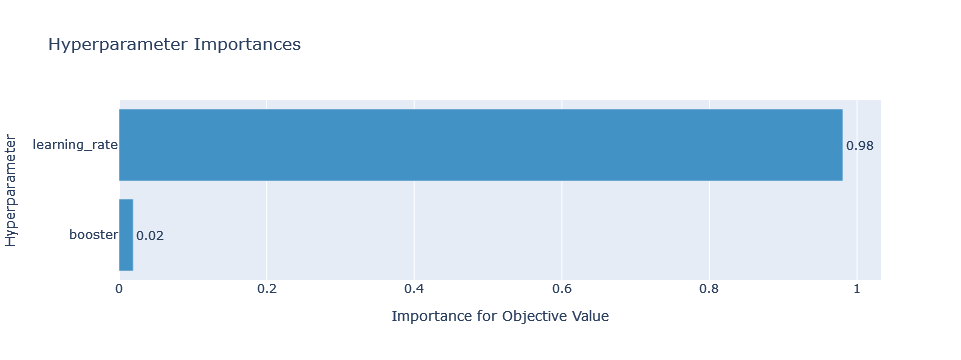

In [83]:
fig = optuna.visualization.plot_param_importances(xgb_study)
fig.show()

In [84]:
#Saving the best xgb model
best_xgb_model_name = 'optuna_save_xgb_mf_2048.dat'

In [85]:
def xgb_reg_detailed_objective(trial):
    
    # Optimizing the booster category.
    booster = trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"])
    
    #Optimizing the learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1.0, log=True)
    
    xgb_model = XGBRegressor(booster = booster, learning_rate = learning_rate)
    
    xgb_model.fit(X_train, Y_train)
    
    Y_val_pred_xgb = xgb_model.predict(X_val)
    
    pickle.dump(xgb_model, open(best_xgb_model_name, 'wb'))
    
    return r2_score(Y_val, Y_val_pred_xgb)

In [86]:
xgb_reg_detailed_objective(xgb_study.best_trial) 

0.7226010183083338

Let us repeat the process we did for the TF-Keras NN model and RF model, and predict on the unseen *test set* and evaluate the performance even more transparently.

In [87]:
#load xgb model
xgb_model = pickle.load(open(best_xgb_model_name, 'rb'))

In [88]:
#Time to predict the test set
Y_pred_xgb = xgb_model.predict(X_test)

In [89]:
df_test_xgb = pd.DataFrame()
df_test_xgb['MolWt_Original'] = Y_test
df_test_xgb['MolWt_Predicted'] = Y_pred_xgb
df_test_xgb.head()

MolWt_Original  MolWt_Predicted
0         342.403       375.051483
1         211.220       259.241760
2         347.783       383.032623
3         369.359       385.891113
4         462.074       202.574265

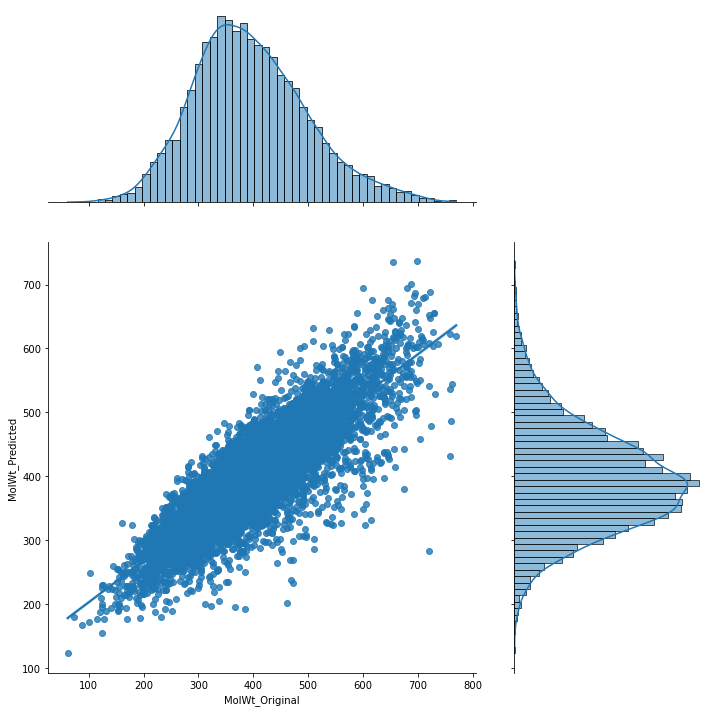

In [90]:
#Visualization

sns.jointplot(data=df_test_xgb, x="MolWt_Original", y="MolWt_Predicted", kind="reg", height= 10, ratio=2)

Let's read the performance metrics.

In [91]:
mae = metrics.mean_absolute_error(df_test_xgb['MolWt_Original'], df_test_xgb['MolWt_Predicted'])
mse = metrics.mean_squared_error(df_test_xgb['MolWt_Original'], df_test_xgb['MolWt_Predicted'])
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(df_test_xgb['MolWt_Original'], df_test_xgb['MolWt_Predicted'])


print("Results of sklearn.metrics:")
print("MAE:",mae) 
#(Mean absolute error) represents the difference between the original and 
#predicted values extracted by averaged the absolute difference over the data set

print("MSE:", mse)
# (Mean Squared Error) represents the difference between the original and 
# predicted values extracted by squared the average difference over the data set

print("RMSE:", rmse)
#(Root Mean Squared Error) is the error rate by the square root of MSE

print("R-Squared:", r2)
# (Coefficient of determination) represents the coefficient of how well the values fit 
# compared to the original values. The value from 0 to 1 interpreted as percentages. 
# The higher the value is, the better the model is

Results of sklearn.metrics:
MAE: 42.010035366539036
MSE: 3055.725445970517
RMSE: 55.27861653452008
R-Squared: 0.7140665090463606


Again, let's not compare the test set performance as that's not the idea of this exercise, and I only tuned a few hyperparameters and for a very few trials for sake of convenience. 

In above toy exercise, you got an intro on how you can use Optuna in your own (Cheminformatics) workflow with simple steps. 

#### End words:
* There are a lot of features available with Optuna of interest, especially- pruning unpromising trials, parallelization and more visualizations.
* The Optuna devs and the community are very active! The documentation is very well done too. 